In [1]:
# https://www.kaggle.com/plasticgrammer/customer-revenue-prediction-v2-playground

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import gc
import sys
import math

from pandas.io.json import json_normalize
from datetime import datetime

import os
print(os.listdir("../Input/"))



FileNotFoundError: [WinError 3] The system cannot find the path specified: '../Input/'

In [3]:
gc.enable()

features = ['channelGrouping', 'date', 'fullVisitorId', 'visitId',\
       'visitNumber', 'visitStartTime', 'device.browser',\
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',\
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',\
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',\
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',\
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',\
       'trafficSource.adContent', 'trafficSource.campaign',\
       'trafficSource.isTrueDirect', 'trafficSource.keyword',\
       'trafficSource.medium', 'trafficSource.referralPath',\
       'trafficSource.source', 'customDimensions']

def load_df(csv_path):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    ans = pd.DataFrame()
    dfs = pd.read_csv(csv_path, sep=',',
            converters={column: json.loads for column in JSON_COLUMNS}, 
            dtype={'fullVisitorId': 'str'}, # Important!!
            chunksize=100000)
    for df in dfs:
        df.reset_index(drop=True, inplace=True)
        for column in JSON_COLUMNS:
            column_as_df = json_normalize(df[column])
            column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
            df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

        #print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
        use_df = df[features]
        del df
        gc.collect()
        ans = pd.concat([ans, use_df], axis=0).reset_index(drop=True)
        #print(ans.shape)
    return ans

In [4]:
%%time
train_df = load_df('../Input/train_v2.csv')
test_df = load_df('../Input/test_v2.csv')

print('train date:', min(train_df['date']), 'to', max(train_df['date']))
print('test date:', min(test_df['date']), 'to', max(test_df['date']))

FileNotFoundError: [Errno 2] File b'../Input/train_v2.csv' does not exist: b'../Input/train_v2.csv'

In [4]:
# https://www.kaggle.com/gemartin
def reduce_mem_usage(df):
    
    # iterate through all the columns of a dataframe and modify the data type
    # to reduce memory usage.        
    
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 398042601.00 MB
Memory usage after optimization is: 369000872.00 MB
Decreased by 7.3%
Memory usage of dataframe is 93570317.00 MB
Memory usage after optimization is: 86743304.00 MB
Decreased by 7.3%


In [5]:
# features only in train_df
for c in train_df.columns.values:
    if c not in test_df.columns.values: print(c)

In [6]:
train_df['totals.transactionRevenue'].fillna(0, inplace=True)
train_df['totals.transactionRevenue'] = np.log1p(train_df['totals.transactionRevenue'].astype(float))
print(train_df['totals.transactionRevenue'].describe())


count    1.708337e+06
mean     1.925875e-01
std      1.844057e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.386437e+01
Name: totals.transactionRevenue, dtype: float64


In [7]:
test_df['totals.transactionRevenue'] = np.nan

In [8]:
all_data = train_df.append(test_df, sort=False).reset_index(drop=True)

In [9]:
print(all_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2109926 entries, 0 to 2109925
Data columns (total 30 columns):
channelGrouping               object
date                          int32
fullVisitorId                 object
visitId                       int32
visitNumber                   int16
visitStartTime                int32
device.browser                object
device.deviceCategory         object
device.isMobile               float16
device.operatingSystem        object
geoNetwork.city               object
geoNetwork.continent          object
geoNetwork.country            object
geoNetwork.metro              object
geoNetwork.networkDomain      object
geoNetwork.region             object
geoNetwork.subContinent       object
totals.bounces                object
totals.hits                   object
totals.newVisits              object
totals.pageviews              object
totals.transactionRevenue     float64
trafficSource.adContent       object
trafficSource.campaign        object
t

In [10]:
# null values

null_cnt = train_df.isnull().sum().sort_values()
print(null_cnt[null_cnt > 0])

totals.pageviews                  239
totals.newVisits               400907
totals.bounces                 836759
trafficSource.keyword         1052780
trafficSource.referralPath    1142073
trafficSource.isTrueDirect    1173819
trafficSource.adContent       1643600
dtype: int64


In [11]:
# fillna object feature
for col in ['trafficSource.keyword',
            'trafficSource.referralPath',
            'trafficSource.adContent']:
    all_data[col].fillna('unknown', inplace=True)

# fillna numeric values

all_data['totals.pageviews'].fillna(1, inplace=True)
all_data['totals.newVisits'].fillna(0, inplace=True)
all_data['totals.bounces'].fillna(0, inplace=True)
all_data['totals.pageviews'] = all_data['totals.pageviews'].astype(int)
all_data['totals.newVisits'] = all_data['totals.newVisits'].astype(int)
all_data['totals.bounces'] = all_data['totals.bounces'].astype(int) 

all_data['trafficSource.isTrueDirect'].fillna(False, inplace=True) # boolean value

In [12]:
# drop constant columns

const_col = [col for col in all_data.columns if all_data[col].nunique() == 1]

print('drop columns:', const_col)
all_data.drop(const_col, axis=1, inplace=True)

drop columns: []


In [13]:
# find users with transaction revenue

train_rev = train_df[train_df['totals.transactionRevenue'] > 0].copy()

print(len(train_rev))

train_rev.head()

18514


,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,...,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,customDimensions
433,Organic Search,20171016,9549826748224805897,1508200705,4,1508200705,Chrome,desktop,0.0,Macintosh,...,9,16.536148,NaN,(not set),True,(not provided),organic,NaN,google,"[{'index': '4', 'value': 'North America'}]"
550,Referral,20171016,3700714855829972615,1508192636,11,1508192636,Chrome,desktop,0.0,Windows,...,12,15.894952,NaN,(not set),NaN,NaN,(none),/,(direct),"[{'index': '4', 'value': 'North America'}]"
555,Organic Search,20171016,1572225825161580042,1508162218,6,1508162218,Safari,mobile,1.0,iOS,...,15,17.863811,NaN,(not set),True,(not provided),organic,NaN,google,"[{'index': '4', 'value': 'North America'}]"
597,Referral,20171016,7187192533100162289,1508189401,17,1508189401,Chrome,desktop,0.0,Macintosh,...,16,16.718579,NaN,(not set),True,NaN,(none),/,(direct),"[{'index': '4', 'value': 'North America'}]"
619,Referral,20171016,7889233516776348524,1508190484,1,1508190484,Chrome,desktop,0.0,Macintosh,...,20,16.325923,NaN,(not set),NaN,NaN,(none),/,(direct),"[{'index': '4', 'value': 'North America'}]"


In [14]:
def plotCategoryRateBar(a, b, colName, topN=np.nan):
    if topN == topN: # isNotNan
        vals = b[colName].value_counts()[:topN]
        subA = a.loc[a[colName].isin(vals.index.values), colName]
        df = pd.DataFrame({'All':subA.value_counts() / len(a), 'Revenue':vals / len(b)})
    else:
        df = pd.DataFrame({'All':a[colName].value_counts() / len(a), 'Revenue':b[colName].value_counts() / len(b)})
    df.sort_values('Revenue').plot.barh()

In [15]:
format_str = '%Y%m%d'
all_data['formated_date'] = all_data['date'].apply(lambda x: datetime.strptime(str(x), format_str))
all_data['_year'] = all_data['formated_date'].apply(lambda x:x.year)
all_data['_month'] = all_data['formated_date'].apply(lambda x:x.month)
all_data['_quarterMonth'] = all_data['formated_date'].apply(lambda x:x.day//8)
all_data['_day'] = all_data['formated_date'].apply(lambda x:x.day)
all_data['_weekday'] = all_data['formated_date'].apply(lambda x:x.weekday())

all_data.drop(['date','formated_date'], axis=1, inplace=True)

In [16]:
all_data['_visitStartHour'] = all_data['visitStartTime'].apply(
    lambda x: str(datetime.fromtimestamp(x).hour))

unique customDimensions count: 6


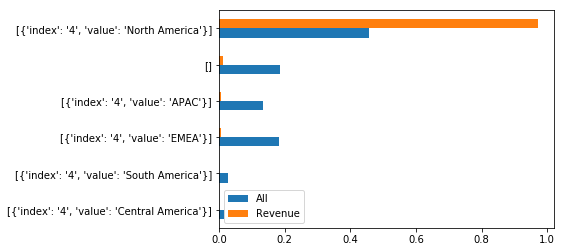

In [17]:
# custom Dimensions

print('unique customDimensions count:', train_df['customDimensions'].nunique())
plotCategoryRateBar(all_data, train_rev, 'customDimensions')

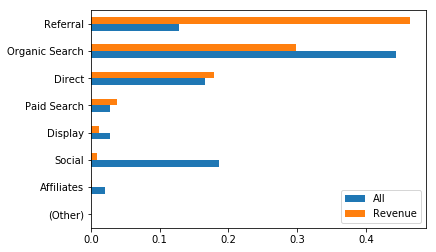

In [18]:
plotCategoryRateBar(all_data, train_rev, 'channelGrouping')

In [19]:
print('train all:', len(train_df))
print('train unique fullVisitorId:', train_df['fullVisitorId'].nunique())
print('train unique visitId:', train_df['visitId'].nunique())
print('-' * 30)
print('test all:', len(test_df))
print('test unique fullVisitorId:', test_df['fullVisitorId'].nunique())
print('test unique visitId:', test_df['visitId'].nunique())


train all: 1708337
train unique fullVisitorId: 1323730
train unique visitId: 1665802
------------------------------
test all: 401589
test unique fullVisitorId: 296530
test unique visitId: 393181


unique browser count: 129


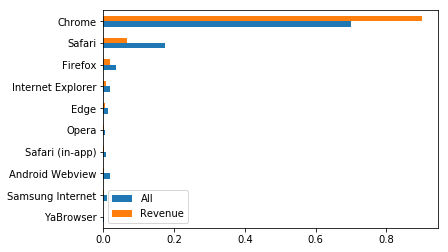

In [20]:
print('unique browser count:', train_df['device.browser'].nunique())
plotCategoryRateBar(all_data, train_rev, 'device.browser', 10)

In [21]:
null_cnt = all_data.isnull().sum().sort_values()
print(null_cnt[null_cnt > 0])

totals.transactionRevenue    401589
dtype: int64


In [22]:
all_data.drop(['visitId','visitStartTime'],axis=1,inplace=True)

for i, t in all_data.loc[:, all_data.columns != 'fullVisitorId'].dtypes.iteritems():
    if t == object:
        all_data[i].fillna('unknown', inplace=True)
        all_data[i] = pd.factorize(all_data[i])[0]

In [23]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2109926 entries, 0 to 2109925
Data columns (total 33 columns):
channelGrouping               int64
fullVisitorId                 object
visitNumber                   int16
device.browser                int64
device.deviceCategory         int64
device.isMobile               float16
device.operatingSystem        int64
geoNetwork.city               int64
geoNetwork.continent          int64
geoNetwork.country            int64
geoNetwork.metro              int64
geoNetwork.networkDomain      int64
geoNetwork.region             int64
geoNetwork.subContinent       int64
totals.bounces                int32
totals.hits                   int64
totals.newVisits              int32
totals.pageviews              int32
totals.transactionRevenue     float64
trafficSource.adContent       int64
trafficSource.campaign        int64
trafficSource.isTrueDirect    bool
trafficSource.keyword         int64
trafficSource.medium          int64
trafficSource.refer

In [31]:
train_df = all_data[all_data['totals.transactionRevenue'].notnull()]
test_df = all_data[all_data['totals.transactionRevenue'].isnull()].drop(['totals.transactionRevenue'], axis=1)

NameError: name 'all_data' is not defined

In [32]:
test_df.shape

NameError: name 'test_df' is not defined

In [33]:
train_id = train_df['fullVisitorId']
test_id = test_df['fullVisitorId']

Y_train_reg = train_df.pop('totals.transactionRevenue')
X_train = train_df.drop(['fullVisitorId'], axis=1)
X_test  = test_df.drop(['fullVisitorId'], axis=1)

print(X_train.shape, X_test.shape)

NameError: name 'train_df' is not defined

In [34]:
del all_data, train_df, test_df, train_rev
gc.collect()

print(pd.DataFrame([[val for val in dir()], [sys.getsizeof(eval(val)) for val in dir()]],
                   index=['name','size']).T.sort_values('size', ascending=False).reset_index(drop=True)[:10])

NameError: name 'all_data' is not defined

In [35]:
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb